In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
tf = torchvision.transforms.ToTensor()
nm = torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
from pathlib import Path
from tqdm import tqdm
import PIL
import yaml
from omegaconf import OmegaConf

from rqvae.models.rqvae.rqvae import RQVAE
from rqvae.utils.config import load_config, augment_arch_defaults
from rqvae.models import create_model


In [6]:
model_path = Path("/home/sake/userdata/sake/rq-vae-transformer-latent-score/logs/gsrqvae_f16_c1024_k4_unshared_128p_gray_unfit/11122024_173629/epoch1370_model.pt")

config_path = Path("/home/sake/userdata/sake/rq-vae-transformer-latent-score/logs/gsrqvae_f16_c1024_k4_unshared_128p_gray_unfit/11122024_173629/config.yaml")
config = OmegaConf.load(config_path)


In [7]:
config = load_config(config_path)
config.arch = augment_arch_defaults(config.arch)

In [8]:
model, _ = create_model(config.arch)
model.load_state_dict(torch.load(model_path)["state_dict"])
model.eval()
model.cuda()


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/tmp/ipykernel_207483/2352991578.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)["state_dict"])


RQVAE(
  (encoder): Encoder(
    (conv_in): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0-1): 2 x Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=True)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (2): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2

In [9]:
img_paths = list(Path("/home/sake/userdata/olimpic_dataset/grandstaff-lmx").rglob("**/*_128.jpg"))

In [10]:
image = PIL.Image.open(list(img_paths)[10000])

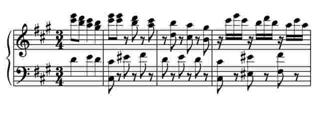

In [11]:
image

In [12]:
image = tf(image)
image = nm(image)
image
image.shape

torch.Size([1, 128, 324])

In [34]:
out = model.get_codes(image.unsqueeze(0).cuda())
out.shape


torch.Size([1, 8, 20, 4])

In [44]:
decoded = model.decode_code(out)
decoded.shape

torch.Size([1, 1, 128, 320])

In [46]:
import cv2

cv2.imwrite(str("temp.png"), (decoded*255).squeeze(0).squeeze(0).cpu().numpy())

True

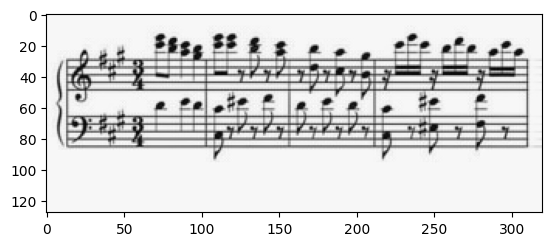

In [39]:
import matplotlib.pyplot as plt
plt.imshow(decoded.squeeze(0).squeeze(0).cpu().numpy(), cmap='gray')
plt.show()


In [34]:
x_y_shifted_toks = []
for i in range(16):
  x_shifted_img = image[...,i:image.shape[-1]-15+i]
  y_shifted_imgs = []
  for j in range(4):
    y_shifted_imgs.append(torch.nn.functional.pad(x_shifted_img[:, j:x_shifted_img.shape[-2]-4+j], (0, 0, 4-j, j), mode='replicate'))
  y_shifted_imgs = torch.stack(y_shifted_imgs)
  out = model.get_codes(y_shifted_imgs.cuda())
  x_y_shifted_toks.append(out.squeeze(0))
x_y_shifted_toks = torch.stack(x_y_shifted_toks)
x_y_shifted_toks.shape


torch.Size([16, 4, 8, 19, 4])

---